<a href="https://colab.research.google.com/github/ntontonto/kaggle/blob/master/Sprint4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  - Product Backlog / Sprint Backlog
      - LightGBMの知見を深める系
          - 各パラメータの意味をまとめる（Mitty） >> OK
            - バギングについても追加しておく
          - LightGBMに適している入力データの形式に関する知見を深める
              - onehot / Labelencodingの比較を行う（Kenty） ⇒ Done
              - Box-Cox変換を行う（Mitty）
              - 対数変換を行う（Kenty） ⇒ Done
      - 改善系
          - kaggle.jsonのdrive配置（Mitty） >> OK
          - 特徴量管理方法の関数化（Kenty）
          - パラメータチューニング結果をdbで保存（Mitty）>> OK
          - Githubでバージョン管理する（Kenty）
      - ー－－－－－－－－－－－－－
      - モデルの学習に関する知識を深める
          - 過学習防止策のドキュメント化（Mitty）>> OK
          - クロスバリデーションの意義をまとめる（Kenty）
          - クロスバリデーションでパラメータチューニング（Mitty）>> OK
          - どのような時にPrivate / Public Scoreの乖離が発生するかを調べる（Kenty）
          - パラメータチューニングのやり方をまとめる（Mitty）
      - その他の知見を深める
          - 重要度を参考に、特徴量を更新
          - 各説明変数の重要度変数の可視化と応用
          - 欠損値の埋め方を工夫したい
          - 新しい特徴量を作成する
      - これを読む：https://tech.connehito.com/entry/2019/11/15/110000


# LightGBM の知見を深める

## 各パラメータの意味をまとめる（Mitty）

### 前提知識
- ゲイン
  - 情報利得のこと
  - 子ノードが親ノードに比べてどのくらい綺麗に分類できているかを表す指標のこと
  - あるいは各ノードで標準偏差がどのくらい減るかを表した指標のこと

#### アンサンブル学習
##### バギング
- 並列で弱学習器を用いてそれぞれのモデルの総合的な結果を用いて判断する
- トレーニングデータに対していろんなモデルを構築して、それぞれの結果を集約化
- 回帰だったら平均値、分類だったら多数決

##### ブースティング
- 弱学習器を直列的に学習していく
- 最初の木ではトレーニングデータに対して全て等しい重みづけを行い学習を行う
  - 謝った分類のデータに対して高い重みづけを行う
- 重み付けされたトレーニングデータセットを次の木に入力、予測値を含めたデータで再度学習
- 何度もサイクルを繰り返しによって弱学習器にから、1つの強学習器へと変換する


##### スタッキング
- foldで分けて、各モデルで予測を行う
- 予測値を新たな特徴量とする
- それを何回か繰り返す

### パラメータの種類と説明
- num_iterations ( n_estimators)
  - 作成する木の数。アーリーストッピングで過学習になるのを防ぐため基本的には大きい値で設定してよし、defalut = 100
  - mittyはひどい時で一万に設定していた時もある
- max_depth
  - 木の深さの最大値。大きすぎると決定木の分岐が大きくなるため、大きくしすぎない方が良いらしい。サイトによると7が無難らしいが、mittyは以前11に設定して精度が良かったため、ハイパラで最適値探しても良さそう。
- reg_alpha
  - L1正則化項の係数(小さいほど過学習寄り)
  - 一般的にはαの方が通じると思う
  - L1正則化に相当するため、重要じゃない特徴量が落とされる。過学習を抑制する。default = 0
- reg_lambda
  -L2正則化項の係数(小さいほど過学習寄り)
  - L2正則化に相当するため重要じゃない特徴量の影響が小さくなる。過学習を抑制する。
- num_leaves
  - 1本の木の最大葉枚数(大きいほど過学習寄り)
  - max_depthと関係あり、2^max_depthよりは大きくならないため、それ以上に設定するとエラーが起きるため注意、defalut = 31
- colsample_bytree
  - 各決定木においてランダムに抽出される列の割合(大きいほど過学習寄り)
- subsample (bagging_fraction)
  - 各決定木においてランダムに抽出される標本の割合(大きいほど過学習寄り)
  - cross_validation やっているなら最適化する必要なさそう
- subsample_freq
  - subsample_freqの数だけバギング実施(大きいほど過学習寄りだが、0のときバギング非実施となるので注意)
- min_child_samples
  - 1枚の葉に含まれる最小データ数,　小さいほど細かくグループ分けされる？(小さいほど過学習寄り)
- min_gain_to_split
  - 決定木ではゲインが最大となるような分割がされ、その分割するゲインの最小値を指定。それ以下になると分割がされなくなる。（それ以上木が深くなくなる）
- feature_fraction(colsample_bytree)
  - 各木を作成するときに何%の特徴量をランダムで使うかの指標。default = 1.0 >> 全て使うようにしている
  - 例えば、0.5だと半分の特徴量をランダムで選んで使う
  - 特徴量の数が多いときには使えそうな気がする

### チューニングする必要がないパラメータ
- learning rate
- early_stopping
-  verbose
- seed

### 精度向上するには
- max_binを上げる
  - 分割（分岐）点を増やすため複雑になる
- num_iterationsを一万くらいにしとく
- num_leaves を増やす

### 過学習防止策
- max_binを小さめにする
  - max_bin:
    - 決定木における条件分岐の数に影響を与える、大きくするほどbinの数が多くなり、その分葉が増える
- 小さなnum_leavesにする
  - num_leaves:
    - 一つの木における最大葉数
- min_data_in_leafを増やす
  - min_data_in_leaf:
      - 一つの葉に属するデータ数
        - 分岐された中のデータ数が小さいほど、細かく分岐していると解釈、そのため最低限必要なデータ数を大きくすることで、おおまかに分割されるためオーバーフィッティング防止策と言える
- bagging_fraction・feature_fractionを設定する、各木ごとに使われるデータ量や特徴量がランダムで選択されるため木ごとに多様化する

### 結局どのパラメータを調整するか？
- num_leaves
- min_data_in_leaf
- max_depth

## 入力データの形式に関する知見を深める

## 実験を行う前の下準備

### データの取得（Shared foleder の名前確認してね）

In [ ]:
# set competitoin name
competition_name = "spaceship-titanic"


from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/NIGHT LAB (1)/Kaggle_1/data/kaggle_json'

# Navigate into Drive where you want to store your Kaggle data
try:
  os.mkdir(f'/content/drive/MyDrive/NIGHT LAB (1)/Kaggle_1/data/{competition_name}/')
except:
  pass
os.chdir(f'/content/drive/MyDrive/NIGHT LAB (1)/Kaggle_1/data/{competition_name}/')
!kaggle competitions download -c {competition_name} # copy from competition page!
!unzip {competition_name}.zip

Mounted at /content/drive
spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spaceship-titanic.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.upload()
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c spaceship-titanic # copy from competition page!
# !unzip spaceship-titanic.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: ignored

### Import libraries

In [ ]:
# 基本的なライブラリ
import numpy as np
import pandas as pd

# 可視化系のライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE)
BACKCOLOR = '#f6f5f5'

from IPython.core.display import HTML

# 統計的な手法を行う際のライブラリ
import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random


# 前処理や評価指標系
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate

# その他
import warnings
!pip install optuna
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### all_data の作成 （train と test を一括で操作するため）

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

### 特徴量の作成


#### Pct[支出系のカラム名]：総支出に占める各支出項目ごとの割合

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']
all_data['PctRoomService'] = all_data['RoomService']/all_data['TotalSpend']
all_data['PctFoodCourt'] = all_data['FoodCourt']/all_data['TotalSpend']
all_data['PctShoppingMall'] = all_data['ShoppingMall']/all_data['TotalSpend']
all_data['PctSpa'] = all_data['Spa']/all_data['TotalSpend']
all_data['PctVRDeck'] = all_data['VRDeck']/all_data['TotalSpend']

#### port/num/deckを分割する

In [ ]:
all_data.loc[:,['Room']] = all_data.PassengerId.apply(lambda x: x[0:4] )
all_data['Deck'] = all_data.Cabin.apply(lambda x:str(x)[:1])
all_data['Side'] = all_data.Cabin.apply(lambda x:str(x)[-1:])
all_data["Cabin_num"] = all_data["Cabin"].str.split("/",expand=True)[1]

#### Room と Cabin_num をintにキャスト

In [ ]:
all_data["Room"] = all_data["Room"].astype("int")
all_data["Cabin_num"] = all_data["Cabin_num"].fillna(0).astype("int")
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      12970 non-null  object 
 1   HomePlanet       12682 non-null  object 
 2   CryoSleep        12660 non-null  object 
 3   Cabin            12671 non-null  object 
 4   Destination      12696 non-null  object 
 5   Age              12700 non-null  float64
 6   VIP              12674 non-null  object 
 7   RoomService      12707 non-null  float64
 8   FoodCourt        12681 non-null  float64
 9   ShoppingMall     12664 non-null  float64
 10  Spa              12686 non-null  float64
 11  VRDeck           12702 non-null  float64
 12  Name             12676 non-null  object 
 13  Transported      8693 non-null   object 
 14  TotalSpend       11607 non-null  float64
 15  PctRoomService   6749 non-null   float64
 16  PctFoodCourt     6749 non-null   float64
 17  PctShoppingMa

### 欠損値の補完

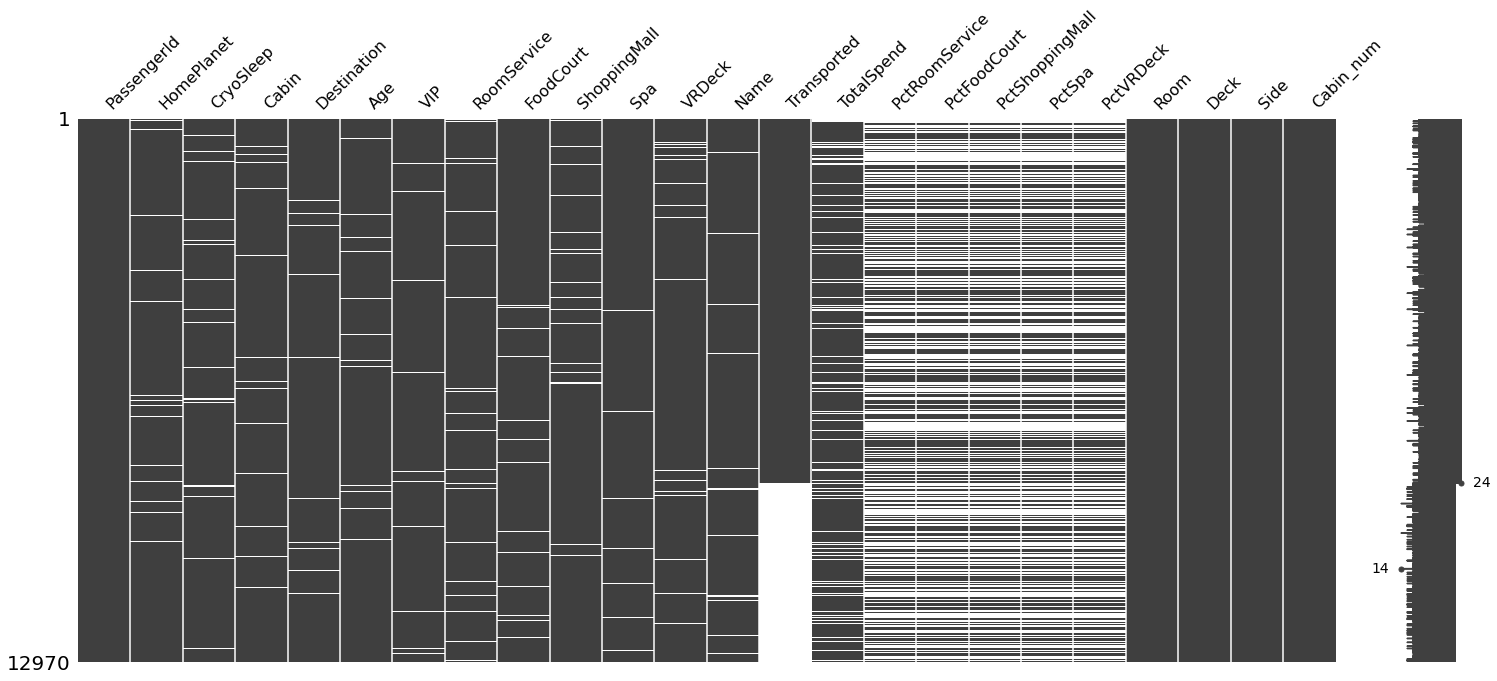

In [ ]:
import missingno as msno
msno.matrix(all_data)

#### 年齢は中央値、支出系は0で埋める

In [ ]:
all_data["Age"].fillna(all_data["Age"].median(), inplace=True)
op_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for col in op_cols:
  all_data[col].fillna(0, inplace=True)

#### ゼロ除算されたPctカラムは、0で埋める

In [ ]:
op_cols = ["PctRoomService", "PctFoodCourt", "PctShoppingMall", "PctSpa", "PctVRDeck"]
for col in op_cols:
  all_data[col].fillna(0, inplace=True)

#### Nameは "Unknown Unknown"で埋める（one-hotができないため）

In [ ]:
all_data['Name'].fillna("Unknown Unknown", inplace=True)

#### TotalSpend：個人の総支出額

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

### onehot / Labelencodingの実施による性能の比較を行う（Kenty）

#### Name, PassengerId は le 固定

In [ ]:
le = LabelEncoder()
all_data["Name"] = le.fit_transform(all_data["Name"])
all_data["PassengerId"] = le.fit_transform(all_data["PassengerId"])
all_data["Cabin"] = le.fit_transform(all_data["Cabin"])

#### Label Encoder の場合の性能を確認

##### カテゴリ変数をLabel Encoding

In [ ]:
all_data_le = all_data.copy()
for col in all_data_le.columns[all_data_le.dtypes == object]:
    if col != 'Transported':
        le = LabelEncoder()
        all_data_le[col] = le.fit_transform(all_data_le[col])
all_data_le.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,TotalSpend,PctRoomService,PctFoodCourt,PctShoppingMall,PctSpa,PctVRDeck,Room,Deck,Side,Cabin_num
0,0,1,0,208,2,39.0,0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0
1,1,0,0,3241,2,24.0,0,109.0,9.0,25.0,...,736.0,0.148098,0.012228,0.033967,0.745924,0.059783,2,5,1,0
2,2,1,0,1,2,58.0,1,43.0,3576.0,0.0,...,10383.0,0.004141,0.344409,0.000000,0.646730,0.004719,3,0,1,0
3,3,1,0,1,2,33.0,0,0.0,1283.0,371.0,...,5176.0,0.000000,0.247875,0.071677,0.643161,0.037287,3,0,1,0
4,4,0,0,3243,2,16.0,0,303.0,70.0,151.0,...,1091.0,0.277727,0.064161,0.138405,0.517874,0.001833,4,5,1,1


In [ ]:
print(all_data_le.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'TotalSpend', 'PctRoomService', 'PctFoodCourt',
       'PctShoppingMall', 'PctSpa', 'PctVRDeck', 'Room', 'Deck', 'Side',
       'Cabin_num'],
      dtype='object')


In [ ]:
feature_columns = all_data_le.columns #全部突っ込む場合、上のように特徴量を選びたい場合はこの行をコメントアウト

##### Train と Test を分割する

In [ ]:
train, X_test = all_data_le[feature_columns].iloc[:train.shape[0]], all_data_le[feature_columns].iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(8693, 23)
(8693,)
(4277, 23)


##### y_train の Transported が bool型になっている（分類器に入れられない）ので、intに変換

In [ ]:
# y_train が bool型になっているので、intに変換する
y_train = y_train.astype("int")

##### Validate のため、Train をさらに分割する

In [ ]:
X_train_va, X_test_va, y_train_va, y_test_va  = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print(X_train_va.shape, y_train_va.shape)

(6085, 23) (6085,)


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = LGBMClassifier(objective='binary')

model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc')

# predict with validation data
y_pred = model.predict_proba(X_test_va)[:, 1]
# convert to bool with threshold is 0.5
y_pred = y_pred >= 0.5
#roc_auc_score metric
accuracy = accuracy_score(y_pred,list(y_test_va))

[1]	training's auc: 0.887576	training's binary_logloss: 0.648039	valid_1's auc: 0.860141	valid_1's binary_logloss: 0.65206
[2]	training's auc: 0.894568	training's binary_logloss: 0.610589	valid_1's auc: 0.869277	valid_1's binary_logloss: 0.617255
[3]	training's auc: 0.897171	training's binary_logloss: 0.579455	valid_1's auc: 0.871781	valid_1's binary_logloss: 0.588822
[4]	training's auc: 0.899952	training's binary_logloss: 0.553141	valid_1's auc: 0.874501	valid_1's binary_logloss: 0.564937
[5]	training's auc: 0.903833	training's binary_logloss: 0.530729	valid_1's auc: 0.877608	valid_1's binary_logloss: 0.544775
[6]	training's auc: 0.905992	training's binary_logloss: 0.511111	valid_1's auc: 0.879517	valid_1's binary_logloss: 0.527008
[7]	training's auc: 0.909006	training's binary_logloss: 0.493393	valid_1's auc: 0.882184	valid_1's binary_logloss: 0.511301
[8]	training's auc: 0.909952	training's binary_logloss: 0.478125	valid_1's auc: 0.883568	valid_1's binary_logloss: 0.497534
[9]	train

In [ ]:
print(accuracy)

0.8052147239263804


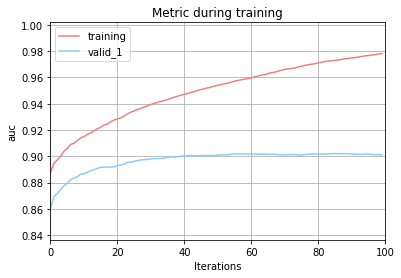

In [ ]:
lgb.plot_metric(model, metric="auc")

##### スコアの提出（Score: 0.79845）

In [ ]:
# predict with validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# convert to bool with threshold is 0.5
y_pred = y_pred_proba >= 0.5
display(y_pred)

submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

array([ True, False,  True, ...,  True,  True,  True])

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


#### One-Hot Encoder の場合の性能を確認

##### カテゴリ変数をLabel Encoding

In [ ]:
all_data_oh = all_data.copy()
categ_nominal = list()
for col in all_data_oh.columns[all_data_oh.dtypes == object]:
    if col != 'Transported':
        all_data_oh = pd.concat([all_data_oh, pd.get_dummies(all_data_oh[col], prefix=col, dummy_na=True)], sort=False, axis=1)
        categ_nominal.append(col)
all_data_oh = all_data_oh.drop(categ_nominal, axis=1)
all_data_oh.head()

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Deck_nan,Side_P,Side_S,Side_n,Side_nan
0,0,208,39.0,0.0,0.0,0.0,0.0,0.0,7819,False,...,0,0,0,0,0,0,1,0,0,0
1,1,3241,24.0,109.0,9.0,25.0,549.0,44.0,6688,True,...,0,1,0,0,0,0,0,1,0,0
2,2,1,58.0,43.0,3576.0,0.0,6715.0,49.0,669,False,...,0,0,0,0,0,0,0,1,0,0
3,3,1,33.0,0.0,1283.0,371.0,3329.0,193.0,10688,False,...,0,0,0,0,0,0,0,1,0,0
4,4,3243,16.0,303.0,70.0,151.0,565.0,2.0,12401,True,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
all_data_oh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12970 non-null  int64  
 1   Cabin                      12970 non-null  int64  
 2   Age                        12970 non-null  float64
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   Name                       12970 non-null  int64  
 9   Transported                8693 non-null   object 
 10  TotalSpend                 12970 non-null  float64
 11  PctRoomService             12970 non-null  float64
 12  PctFoodCourt               12970 non-null  float64
 13  PctShoppingMall            12970 non-null  floa

In [ ]:
feature_columns = all_data_oh.columns #全部突っ込む場合、上のように特徴量を選びたい場合はこの行をコメントアウト

##### Train と Test を分割する

In [ ]:
train, X_test = all_data_oh[feature_columns].iloc[:train.shape[0]], all_data_oh[feature_columns].iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(8693, 45)
(8693,)
(4277, 45)


##### y_train の Transported が bool型になっている（分類器に入れられない）ので、intに変換

In [ ]:
# y_train が bool型になっているので、intに変換する
y_train = y_train.astype("int")

##### Validate のため、Train をさらに分割する

In [ ]:
X_train_va, X_test_va, y_train_va, y_test_va  = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print(X_train_va.shape, y_train_va.shape)

(6085, 45) (6085,)


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = LGBMClassifier(objective='binary')

model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc')

# predict with validation data
y_pred = model.predict_proba(X_test_va)[:, 1]
# convert to bool with threshold is 0.5
y_pred = y_pred >= 0.5
#roc_auc_score metric
accuracy = accuracy_score(y_pred,list(y_test_va))

[1]	training's auc: 0.889894	training's binary_logloss: 0.647769	valid_1's auc: 0.865198	valid_1's binary_logloss: 0.650982
[2]	training's auc: 0.89787	training's binary_logloss: 0.609658	valid_1's auc: 0.873791	valid_1's binary_logloss: 0.615295
[3]	training's auc: 0.901157	training's binary_logloss: 0.57795	valid_1's auc: 0.877433	valid_1's binary_logloss: 0.585874
[4]	training's auc: 0.90469	training's binary_logloss: 0.550832	valid_1's auc: 0.881637	valid_1's binary_logloss: 0.560486
[5]	training's auc: 0.90614	training's binary_logloss: 0.527928	valid_1's auc: 0.883201	valid_1's binary_logloss: 0.538772
[6]	training's auc: 0.908034	training's binary_logloss: 0.507997	valid_1's auc: 0.8853	valid_1's binary_logloss: 0.520387
[7]	training's auc: 0.910266	training's binary_logloss: 0.490704	valid_1's auc: 0.88634	valid_1's binary_logloss: 0.504815
[8]	training's auc: 0.912864	training's binary_logloss: 0.475273	valid_1's auc: 0.888762	valid_1's binary_logloss: 0.491371
[9]	training's 

In [ ]:
print(accuracy)

0.8109662576687117


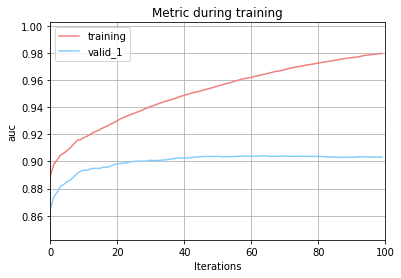

In [ ]:
lgb.plot_metric(model, metric="auc")

##### スコアの提出（Score: 0.79822）

In [ ]:
# predict with validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# convert to bool with threshold is 0.5
y_pred = y_pred_proba >= 0.5
display(y_pred)

submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

array([ True, False,  True, ...,  True,  True,  True])

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


###  Box-Cox変換の実施による性能の比較を行う（Mitty）

#### そもそもBOX-COX変換とは
- データの構造を正規分布にするために用いられる手法
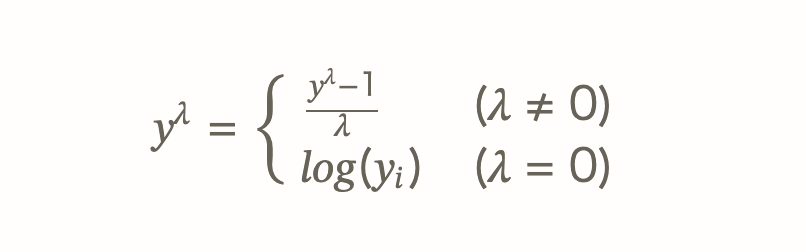

- y : 変換したい変数
- λ : 変換パラメータ

#### BoxCox λ変化による値の変化の仕方
- λを-2~2まで変化させ、変換後の値の変化をみる

In [ ]:
all_data["TotalSpend"] = all_data["TotalSpend"] + 1

In [ ]:
all_data["TotalSpend"]

0           1.0
1         737.0
2       10384.0
3        5177.0
4        1092.0
         ...   
4272        1.0
4273     1019.0
4274        1.0
4275     3204.0
4276        1.0
Name: TotalSpend, Length: 12970, dtype: float64

In [ ]:
all_data = all_data

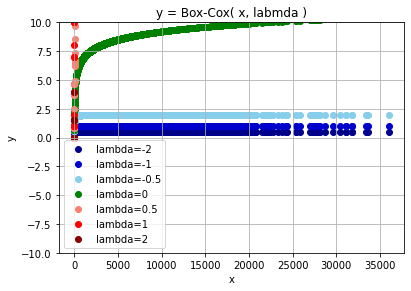

In [ ]:
list_lambda = [-2, -1, -0.5, 0, 0.5, 1, 2]
for i, i_lambda in enumerate(list_lambda):
    all_data[ 'y'+str(i) ] = stats.boxcox( all_data.TotalSpend, lmbda = i_lambda )

fig, ax = plt.subplots()
ax.scatter(all_data.TotalSpend, all_data.y0, color='darkblue',  label="lambda="+str(list_lambda[0]))
ax.scatter(all_data.TotalSpend, all_data.y1, color='mediumblue',label="lambda="+str(list_lambda[1]))
ax.scatter(all_data.TotalSpend, all_data.y2, color='skyblue',   label="lambda="+str(list_lambda[2]))
ax.scatter(all_data.TotalSpend, all_data.y3, color='green',label="lambda="+str(list_lambda[3]))
ax.scatter(all_data.TotalSpend, all_data.y4, color='salmon',    label="lambda="+str(list_lambda[4]))
ax.scatter(all_data.TotalSpend, all_data.y5, color='red',       label="lambda="+str(list_lambda[5]))
ax.scatter(all_data.TotalSpend, all_data.y6, color='darkred',   label="lambda="+str(list_lambda[6]))
ax.legend()
ax.set_title('y = Box-Cox( x, labmda )')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.ylim(-10, 10)
plt.grid()
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()

- λの値によって、値の変換のされ方が大きく違うことがわかる
- λ > 0 , x >> 1
  - 無限大へ変換される
- λ < 0 x << 1
  - 定常

#### 一応AgeのBOXCOX変換前も見ておく

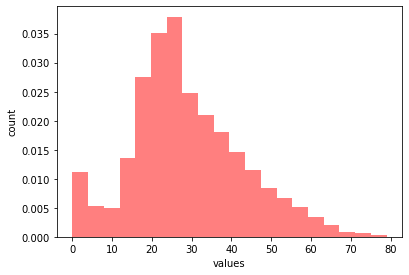

In [ ]:
plt.hist(all_data["Age"], bins=20, color='r', alpha=0.5, density=True)
plt.xlabel('values')
plt.ylabel('count')
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()

#### ラベルエンコードとone-hot encoding の組み合わせ
- ラベルエンコードをした場合は、Box-Cox変換する
- ダミー化した変数に関しては、中身が1か0しかないので、BOX COX変換はしないこととする

In [ ]:
all_data_oh = all_data.copy()
categ_nominal = list()
for col in all_data_oh.columns[all_data_oh.dtypes == object]:
    if col != 'Transported':
      if all_data[col].nunique() > 20:
        le = LabelEncoder()
        all_data_oh[col] = le.fit_transform(all_data_oh[col])
        try:
          all_data_oh[col] = stats.boxcox(all_data_oh[col])[0]
        except:
          all_data_oh[col] = all_data_oh[col] + 1
          all_data_oh[col] = stats.boxcox(all_data_oh[col])[0]
      else:
        all_data_oh = pd.concat([all_data_oh, pd.get_dummies(all_data_oh[col], prefix=col, dummy_na=True)], sort=False, axis=1)
        categ_nominal.append(col)
all_data_oh = all_data_oh.drop(categ_nominal, axis=1)
all_data_oh.head()


,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Deck_nan,Side_P,Side_S,Side_n,Side_nan
0,0,208,39.0,0.0,0.0,0.0,0.0,0.0,7819,False,...,0,0,0,0,0,0,1,0,0,0
1,1,3241,24.0,109.0,9.0,25.0,549.0,44.0,6688,True,...,0,1,0,0,0,0,0,1,0,0
2,2,1,58.0,43.0,3576.0,0.0,6715.0,49.0,669,False,...,0,0,0,0,0,0,0,1,0,0
3,3,1,33.0,0.0,1283.0,371.0,3329.0,193.0,10688,False,...,0,0,0,0,0,0,0,1,0,0
4,4,3243,16.0,303.0,70.0,151.0,565.0,2.0,12401,True,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
all_data_oh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12970 non-null  int64  
 1   Cabin                      12970 non-null  int64  
 2   Age                        12970 non-null  float64
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   Name                       12970 non-null  int64  
 9   Transported                8693 non-null   object 
 10  TotalSpend                 12970 non-null  float64
 11  PctRoomService             12970 non-null  float64
 12  PctFoodCourt               12970 non-null  float64
 13  PctShoppingMall            12970 non-null  floa

In [ ]:
bc_cols = ["Age",'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']

In [ ]:
for col in bc_cols: 
        try:
          all_data_oh[col] = stats.boxcox(all_data_oh[col])[0]
        except:
          all_data_oh[col] = all_data_oh[col] + 1
          all_data_oh[col] = stats.boxcox(all_data_oh[col])[0]

#### 全ての数値データに対してBOX-COX 変換
- 0を含む数値データに対しては、全体に1を追加して対応

#### AgeのBOX COX変換後

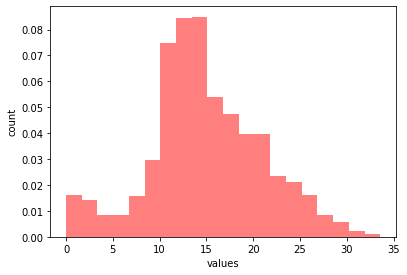

In [ ]:
plt.hist(all_data_oh["Age"], bins=20, color='r', alpha=0.5, density=True)
plt.xlabel('values')
plt.ylabel('count')
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()

### データセット作成(box-cox)

In [ ]:
feature_columns = all_data_oh.columns

In [ ]:
rem_cols = ["y0","y1","y2","y3","y4","y5","y6"]
feature_columns = [i for i in feature_columns if i not in rem_cols]

In [ ]:
feature_columns

['PassengerId',
 'Cabin',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported',
 'TotalSpend',
 'PctRoomService',
 'PctFoodCourt',
 'PctShoppingMall',
 'PctSpa',
 'PctVRDeck',
 'Room',
 'Cabin_num',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'HomePlanet_nan',
 'CryoSleep_False',
 'CryoSleep_True',
 'CryoSleep_nan',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Destination_nan',
 'VIP_False',
 'VIP_True',
 'VIP_nan',
 'Deck_A',
 'Deck_B',
 'Deck_C',
 'Deck_D',
 'Deck_E',
 'Deck_F',
 'Deck_G',
 'Deck_T',
 'Deck_n',
 'Deck_nan',
 'Side_P',
 'Side_S',
 'Side_n',
 'Side_nan']

In [ ]:
train, X_test = all_data_oh[feature_columns].iloc[:train.shape[0]], all_data_oh[feature_columns].iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
# y_train が bool型になっているので、intに変換する
y_train = y_train.astype("int")

#### データセットの中でさらに訓練用と検証用に分割する

In [ ]:
X_train_va, X_test_va, y_train_va, y_test_va  = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print(X_train_va.shape, y_train_va.shape)

(6085, 45) (6085,)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(8693, 45)
(8693,)
(4277, 45)


#### light gbm実装

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = LGBMClassifier(n_estimators = 10000, objective='binary')

model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc', early_stopping_rounds=100)

# predict with validation data
y_pred = model.predict_proba(X_test_va)[:, 1]
# convert to bool with threshold is 0.5
y_pred = y_pred >= 0.5
#roc_auc_score metric
accuracy = accuracy_score(y_pred,list(y_test_va))

[1]	training's auc: 0.889894	training's binary_logloss: 0.647769	valid_1's auc: 0.865198	valid_1's binary_logloss: 0.650982
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.89787	training's binary_logloss: 0.609658	valid_1's auc: 0.873791	valid_1's binary_logloss: 0.615295
[3]	training's auc: 0.901157	training's binary_logloss: 0.57795	valid_1's auc: 0.877433	valid_1's binary_logloss: 0.585874
[4]	training's auc: 0.90469	training's binary_logloss: 0.550832	valid_1's auc: 0.881637	valid_1's binary_logloss: 0.560486
[5]	training's auc: 0.90614	training's binary_logloss: 0.527928	valid_1's auc: 0.883201	valid_1's binary_logloss: 0.538772
[6]	training's auc: 0.907531	training's binary_logloss: 0.508025	valid_1's auc: 0.884812	valid_1's binary_logloss: 0.520646
[7]	training's auc: 0.908293	training's binary_logloss: 0.491224	valid_1's auc: 0.88454	valid_1's binary_logloss: 0.506097
[8]	training's auc: 0.912682	training's binary_logloss: 0.475216	valid_1's

In [ ]:
print(accuracy)

0.8105828220858896


#### スコアの提出

In [ ]:
# predict with validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# convert to bool with threshold is 0.5
y_pred = y_pred_proba >= 0.5
display(y_pred)

submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

array([ True, False,  True, ...,  True,  True,  True])

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


#### score : 0.80009

### データセット作成(org)

In [ ]:
all_data_oh = all_data.copy()
categ_nominal = list()
for col in all_data_oh.columns[all_data_oh.dtypes == object]:
    if col != 'Transported':
      if all_data[col].nunique() > 20:
        le = LabelEncoder()
        all_data_oh[col] = le.fit_transform(all_data_oh[col])
      else:
        all_data_oh = pd.concat([all_data_oh, pd.get_dummies(all_data_oh[col], prefix=col, dummy_na=True)], sort=False, axis=1)
        categ_nominal.append(col)
all_data_oh = all_data_oh.drop(categ_nominal, axis=1)
all_data_oh.head()


,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Deck_nan,Side_P,Side_S,Side_n,Side_nan
0,0,208,39.0,0.0,0.0,0.0,0.0,0.0,7819,False,...,0,0,0,0,0,0,1,0,0,0
1,1,3241,24.0,109.0,9.0,25.0,549.0,44.0,6688,True,...,0,1,0,0,0,0,0,1,0,0
2,2,1,58.0,43.0,3576.0,0.0,6715.0,49.0,669,False,...,0,0,0,0,0,0,0,1,0,0
3,3,1,33.0,0.0,1283.0,371.0,3329.0,193.0,10688,False,...,0,0,0,0,0,0,0,1,0,0
4,4,3243,16.0,303.0,70.0,151.0,565.0,2.0,12401,True,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
feature_columns = all_data_oh.columns

In [ ]:
feature_columns

Index(['PassengerId', 'Cabin', 'Age', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'TotalSpend',
       'PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa',
       'PctVRDeck', 'Room', 'Cabin_num', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5',
       'y6', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'HomePlanet_nan', 'CryoSleep_False', 'CryoSleep_True', 'CryoSleep_nan',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Destination_nan', 'VIP_False', 'VIP_True',
       'VIP_nan', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_n', 'Deck_nan', 'Side_P', 'Side_S', 'Side_n',
       'Side_nan'],
      dtype='object')

In [ ]:
rem_cols = ["y0","y1","y2","y3","y4","y5","y6"]
feature_columns = [i for i in feature_columns if i not in rem_cols]

In [ ]:
len(feature_columns)

46

In [ ]:
train, X_test = all_data_oh[feature_columns].iloc[:train.shape[0]], all_data_oh[feature_columns].iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
# y_train が bool型になっているので、intに変換する
y_train = y_train.astype("int")

#### データセットの中でさらに訓練用と検証用に分割する

In [ ]:
X_train_va, X_test_va, y_train_va, y_test_va  = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print(X_train_va.shape, y_train_va.shape)

(6085, 45) (6085,)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(8693, 45)
(8693,)
(4277, 45)


#### light gbm実装

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = LGBMClassifier(n_estimators = 10000, objective='binary')

model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc')

# predict with validation data
y_pred = model.predict_proba(X_test_va)[:, 1]
# convert to bool with threshold is 0.5
y_pred = y_pred >= 0.5
#roc_auc_score metric
accuracy = accuracy_score(y_pred,list(y_test_va))

ストリーミング出力は最後の 5000 行に切り捨てられました。
[5001]	training's auc: 1	training's binary_logloss: 2.4357e-06	valid_1's auc: 0.886334	valid_1's binary_logloss: 1.38971
[5002]	training's auc: 1	training's binary_logloss: 2.43516e-06	valid_1's auc: 0.886337	valid_1's binary_logloss: 1.38982
[5003]	training's auc: 1	training's binary_logloss: 2.43453e-06	valid_1's auc: 0.886342	valid_1's binary_logloss: 1.38984
[5004]	training's auc: 1	training's binary_logloss: 2.43395e-06	valid_1's auc: 0.886343	valid_1's binary_logloss: 1.38983
[5005]	training's auc: 1	training's binary_logloss: 2.43332e-06	valid_1's auc: 0.886325	valid_1's binary_logloss: 1.38983
[5006]	training's auc: 1	training's binary_logloss: 2.43295e-06	valid_1's auc: 0.886324	valid_1's binary_logloss: 1.38993
[5007]	training's auc: 1	training's binary_logloss: 2.43229e-06	valid_1's auc: 0.88633	valid_1's binary_logloss: 1.38989
[5008]	training's auc: 1	training's binary_logloss: 2.4313e-06	valid_1's auc: 0.886324	valid_1's binary_logloss: 1.3

In [ ]:
print(accuracy)

0.8017638036809815


#### スコアの提出

In [ ]:
# predict with validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# convert to bool with threshold is 0.5
y_pred = y_pred_proba >= 0.5
display(y_pred)

submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

array([False, False,  True, ...,  True,  True,  True])

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


### 対数変換の実施による性能の比較を行う（Kenty）

#### 分布の確認

##### 可視化用関数の定義

In [ ]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [ ]:
print(all_data.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'TotalSpend', 'PctRoomService', 'PctFoodCourt',
       'PctShoppingMall', 'PctSpa', 'PctVRDeck', 'Room', 'Deck', 'Side',
       'Cabin_num', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6'],
      dtype='object')


##### 可視化用関数の定義： 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck' は0に偏っている

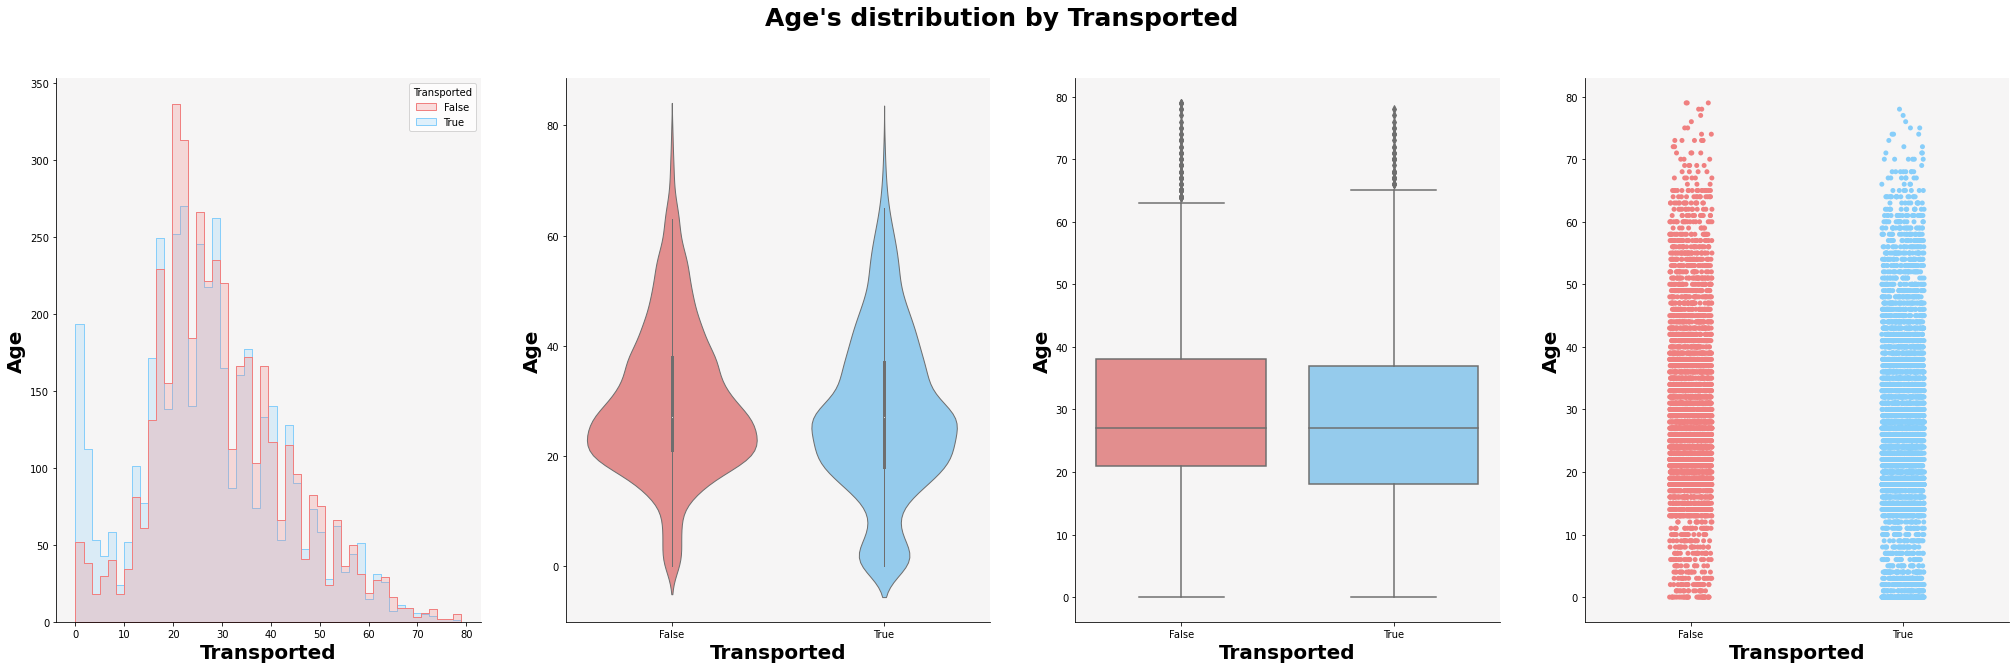

In [ ]:
continuous_dist(train, 'Transported', 'Age')

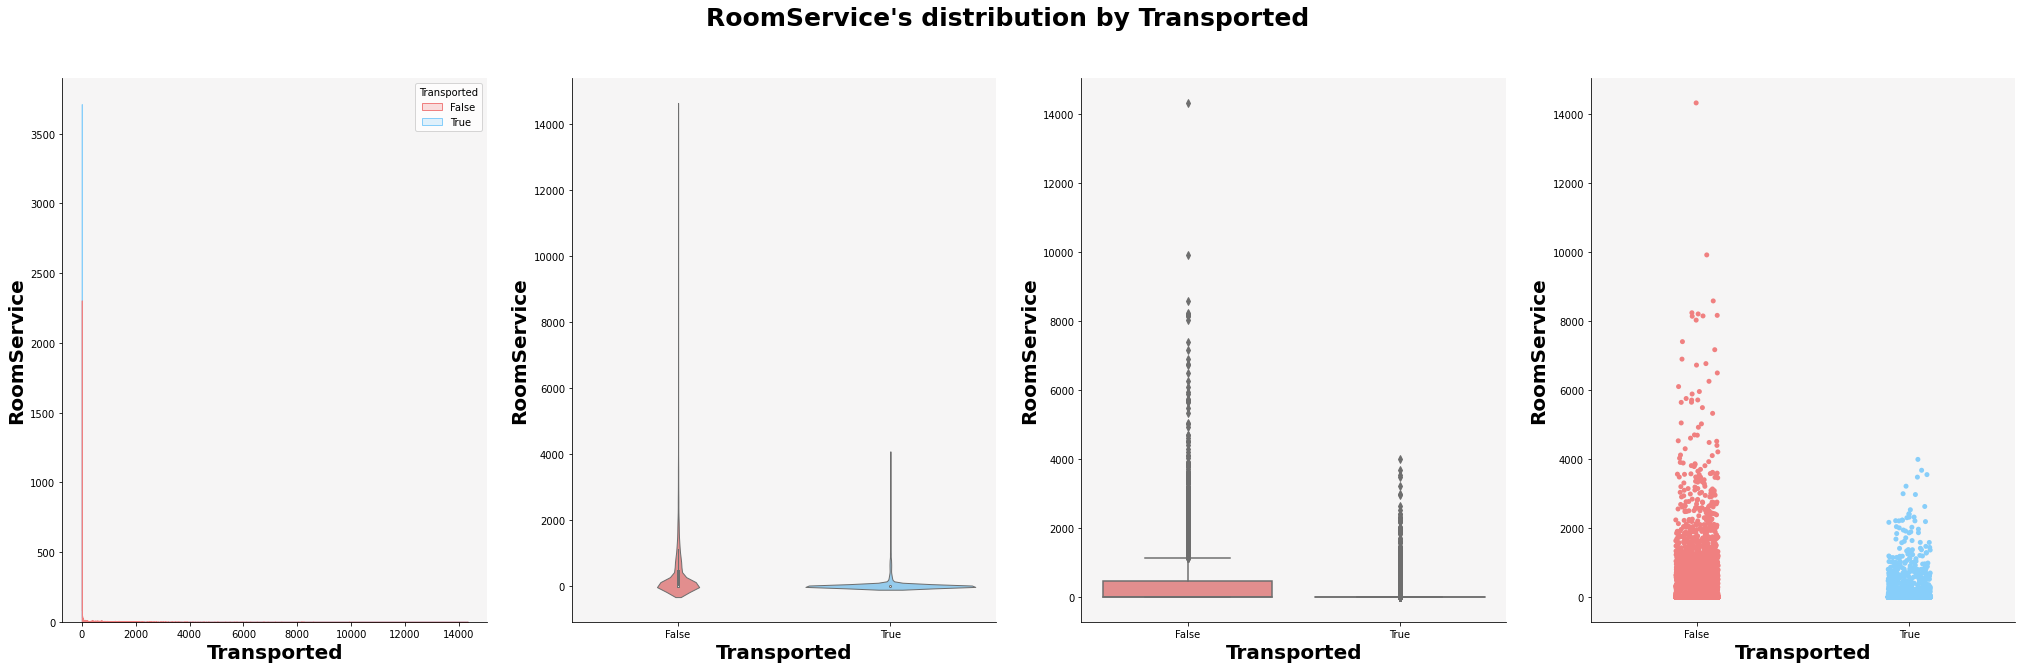

In [ ]:
continuous_dist(train, 'Transported', 'RoomService')

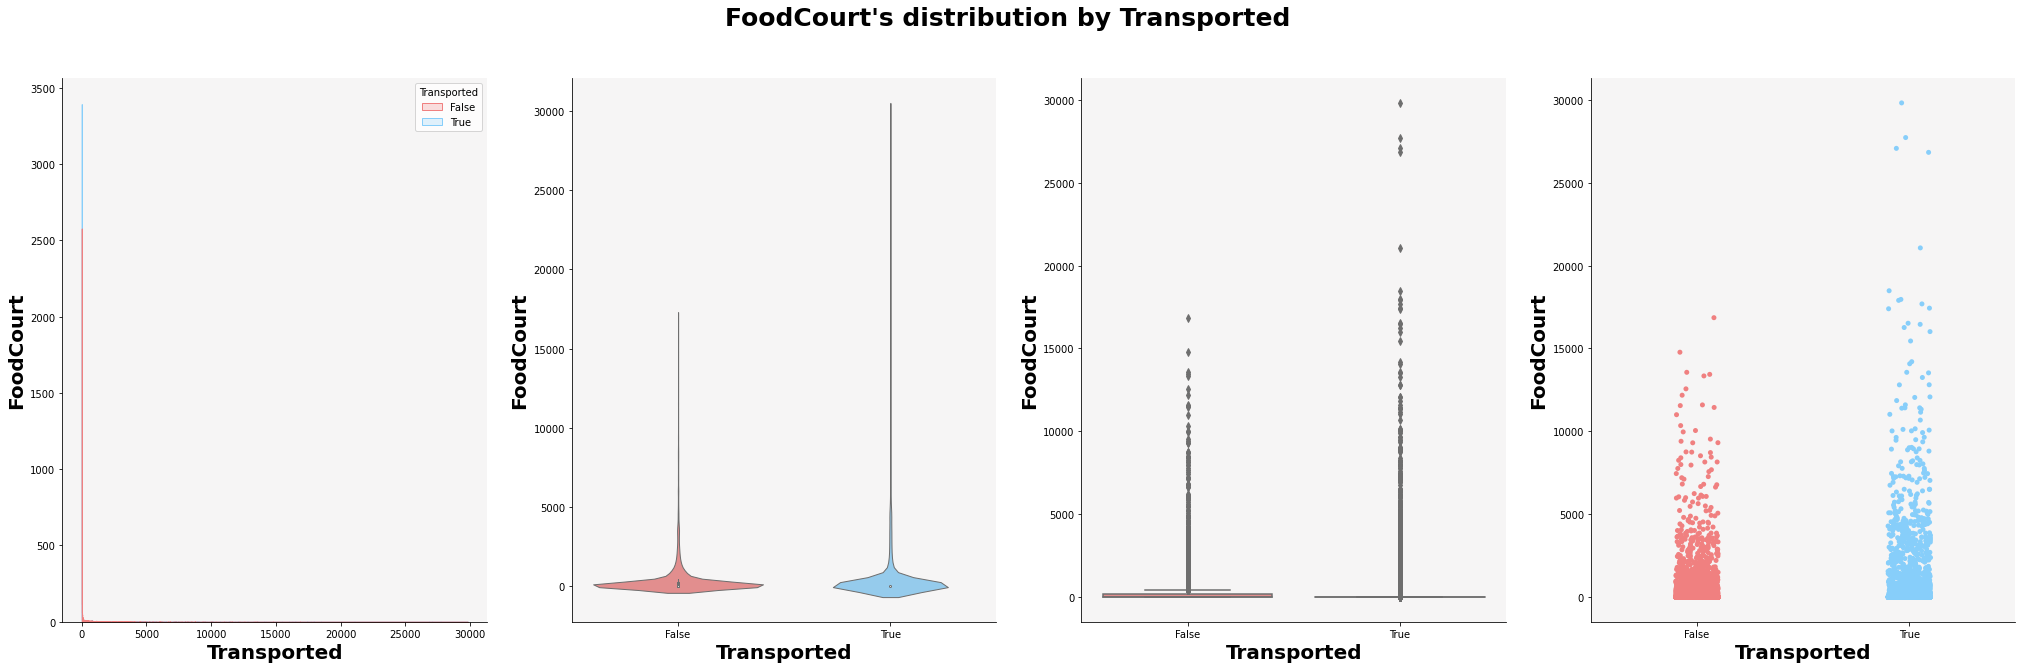

In [ ]:
continuous_dist(train, 'Transported', 'FoodCourt')

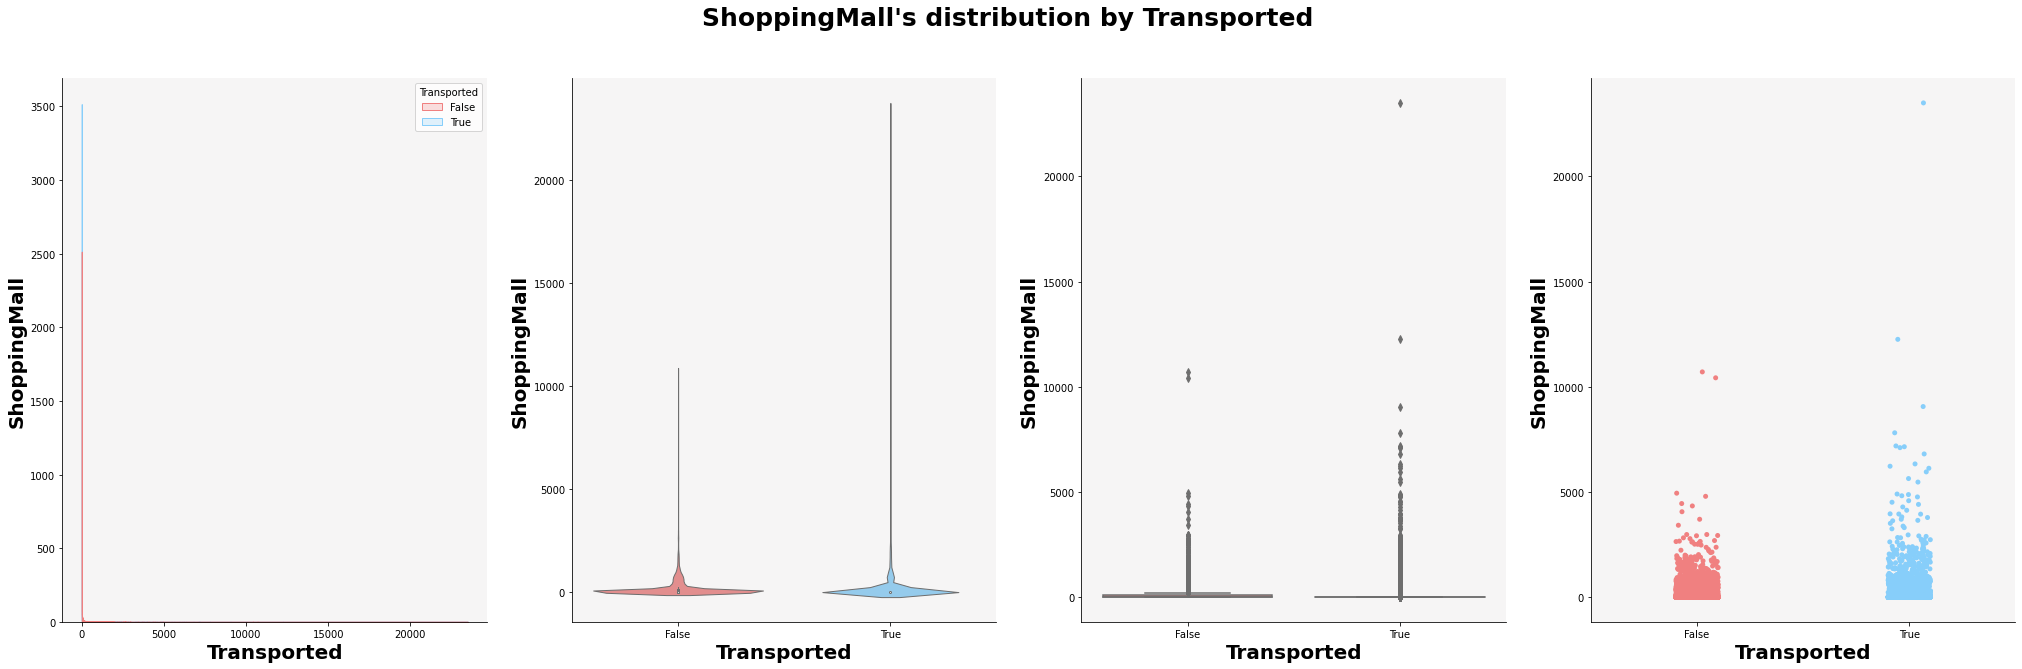

In [ ]:
continuous_dist(train, 'Transported', 'ShoppingMall')

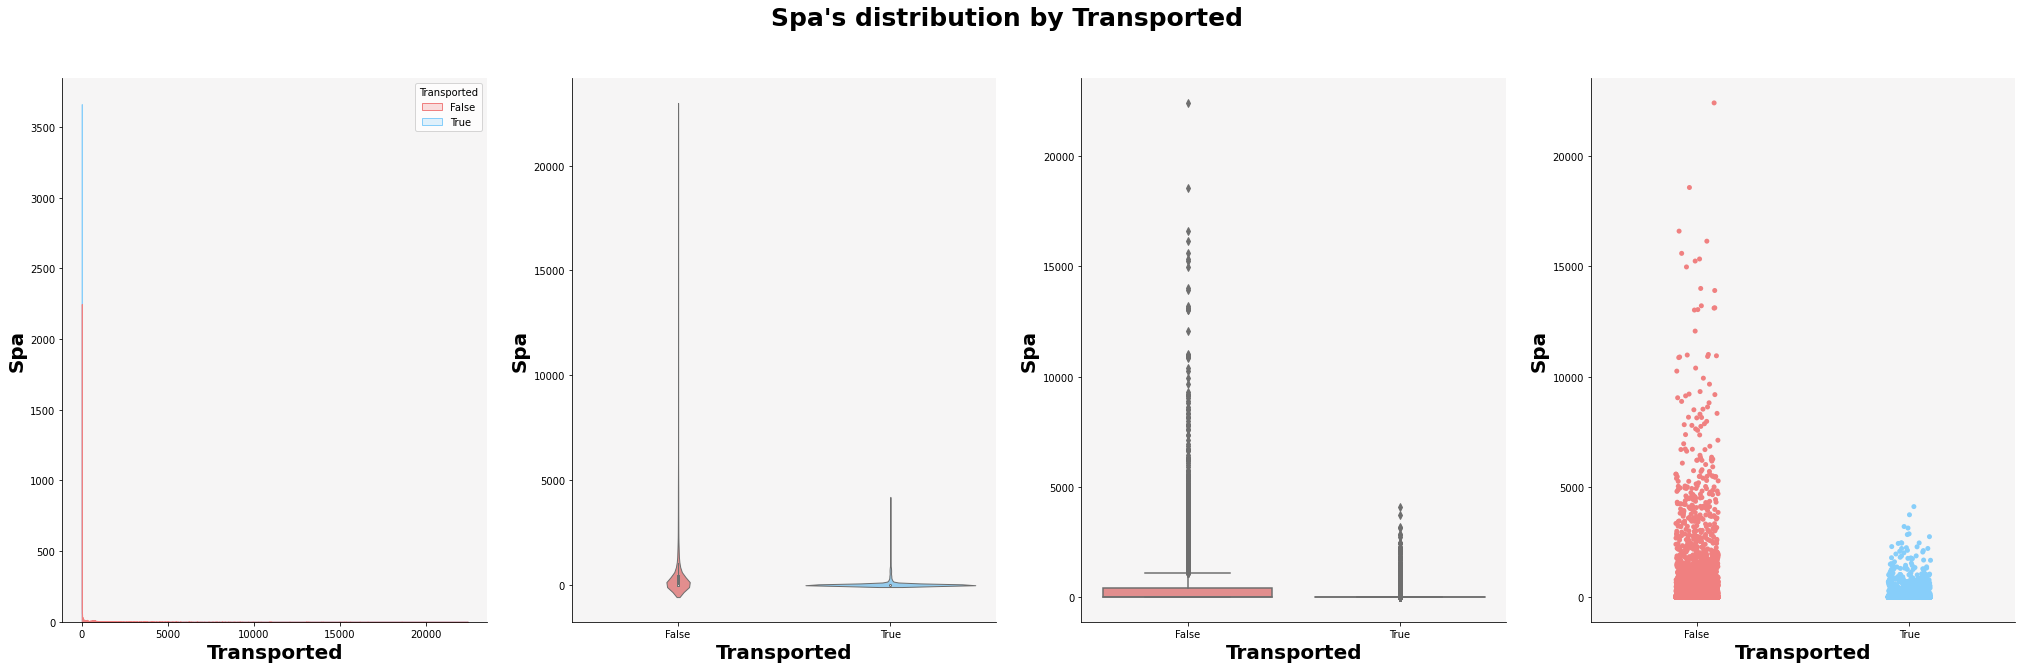

In [ ]:
continuous_dist(train, 'Transported', 'Spa')

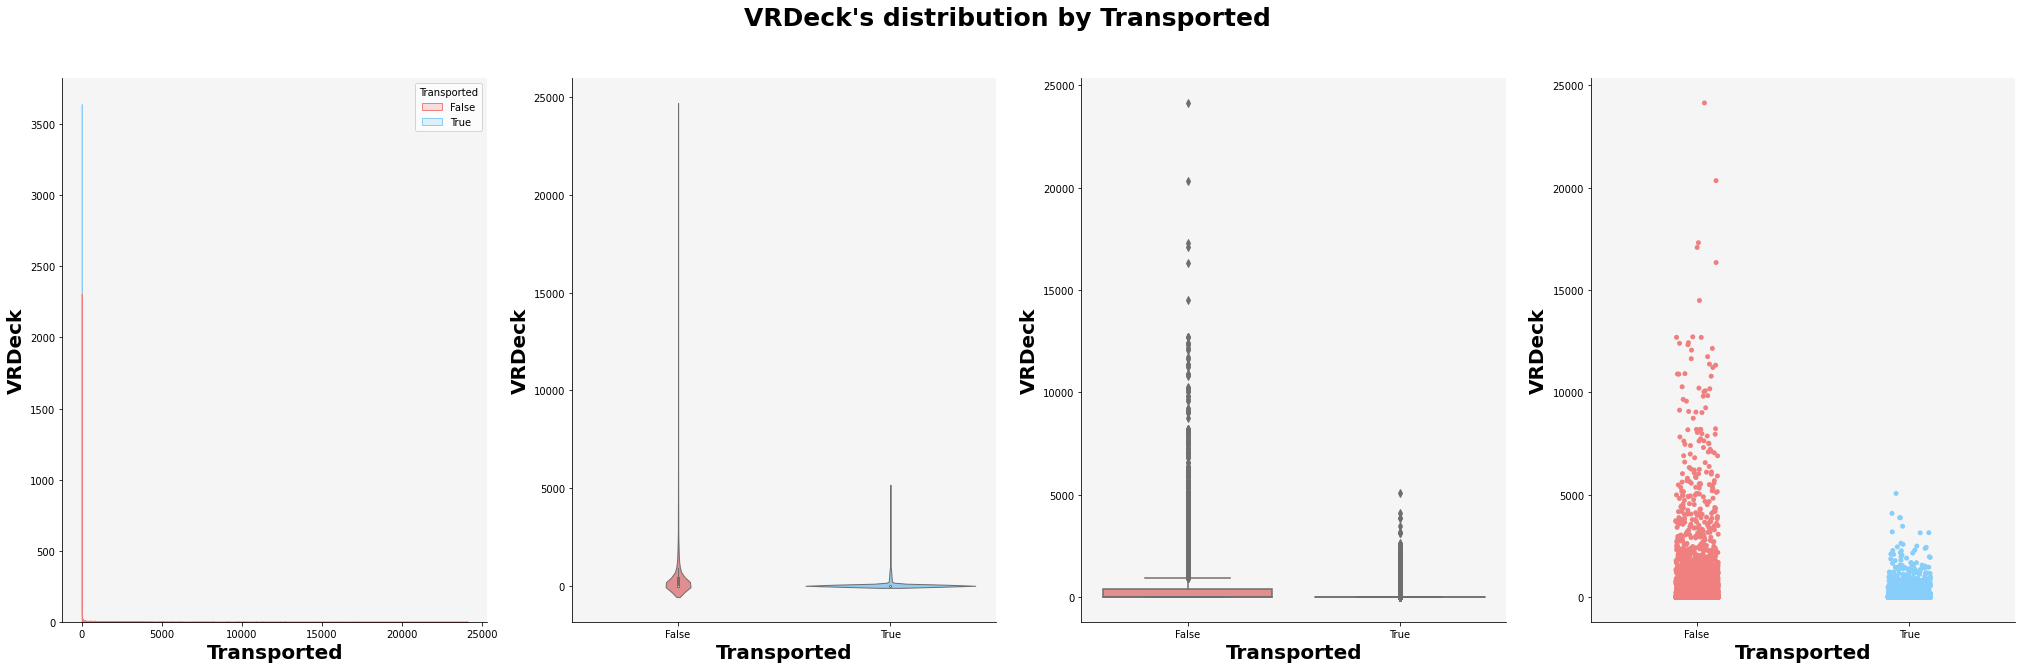

In [ ]:
continuous_dist(train, 'Transported', 'VRDeck')

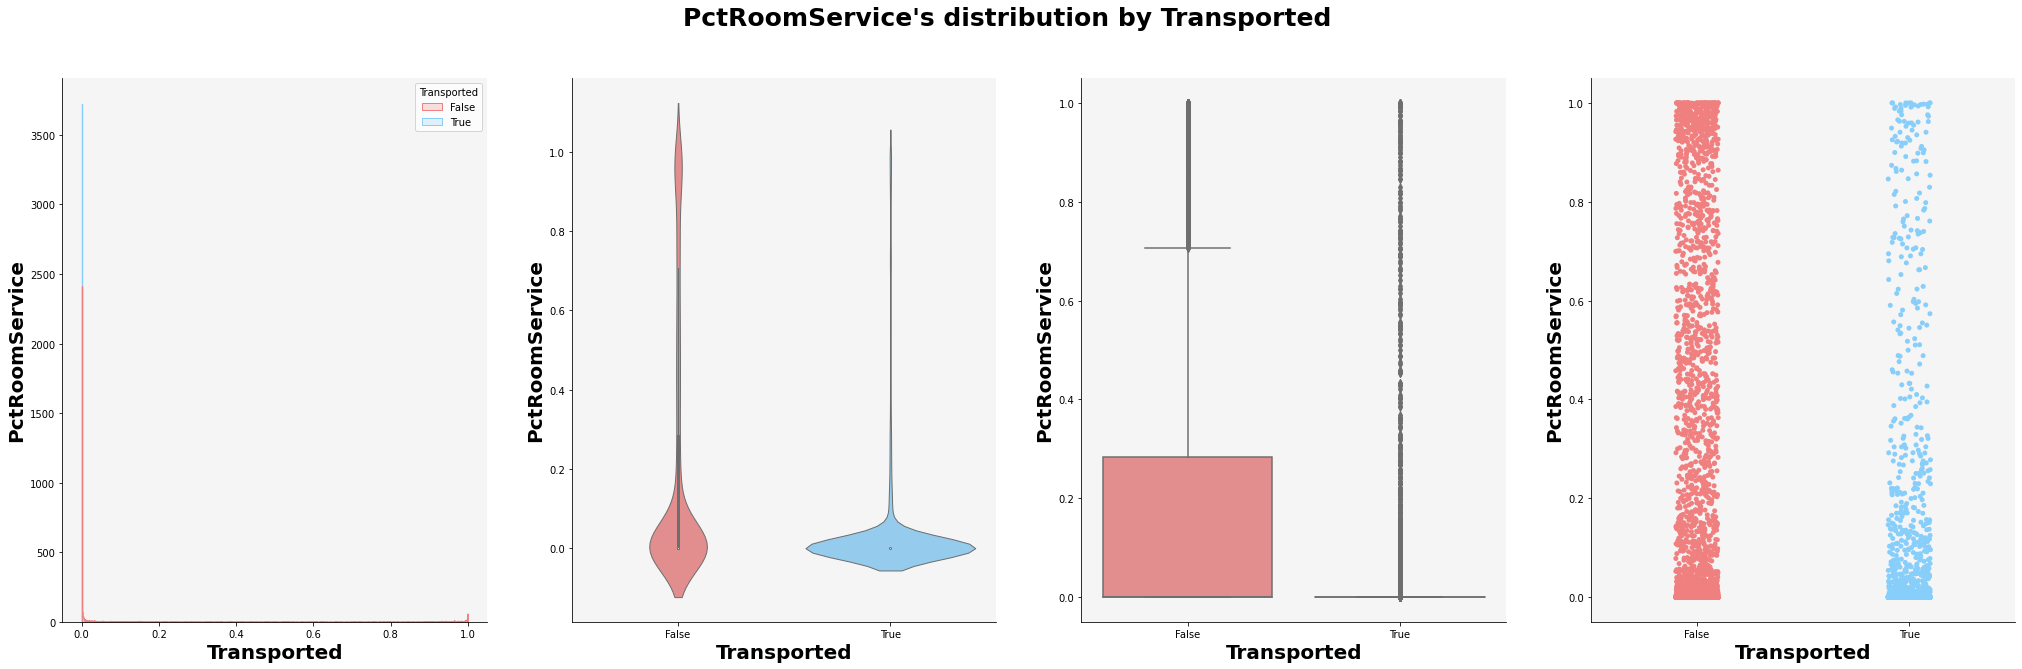

In [ ]:
continuous_dist(train, 'Transported', 'PctRoomService')

##### 対数変換を実施するカラムを決める

In [ ]:
 one_sided_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']

##### 対数変換を実施したカラムを追加する


In [ ]:
all_data_log = all_data.copy()
for col in one_sided_cols:
  all_data_log[col+"_log"] = np.log1p(all_data[col])

In [ ]:
all_data_log.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,RoomService_log,FoodCourt_log,ShoppingMall_log,Spa_log,VRDeck_log,PctRoomService_log,PctFoodCourt_log,PctShoppingMall_log,PctSpa_log,PctVRDeck_log
0,0,Europa,False,208,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,Earth,False,3241,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,4.700480,2.302585,3.258097,6.309918,3.806662,0.138107,0.012154,0.033403,0.557284,0.058064
2,2,Europa,False,1,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,3.784190,8.182280,0.000000,8.812248,3.912023,0.004133,0.295955,0.000000,0.498792,0.004708
3,3,Europa,False,1,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0.000000,7.157735,5.918894,8.110728,5.267858,0.000000,0.221442,0.069225,0.496622,0.036609
4,4,Earth,False,3243,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,5.717028,4.262680,5.023881,6.338594,1.098612,0.245083,0.062187,0.129628,0.417310,0.001832


##### カテゴリ変数のエンコーディング（ラベルエンコーディング）

In [ ]:
for col in all_data_log.columns[all_data_log.dtypes == object]:
    if col != 'Transported':
        le = LabelEncoder()
        all_data_log[col] = le.fit_transform(all_data_log[col])
all_data_log.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,RoomService_log,FoodCourt_log,ShoppingMall_log,Spa_log,VRDeck_log,PctRoomService_log,PctFoodCourt_log,PctShoppingMall_log,PctSpa_log,PctVRDeck_log
0,0,1,0,208,2,39.0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,0,3241,2,24.0,0,109.0,9.0,25.0,...,4.700480,2.302585,3.258097,6.309918,3.806662,0.138107,0.012154,0.033403,0.557284,0.058064
2,2,1,0,1,2,58.0,1,43.0,3576.0,0.0,...,3.784190,8.182280,0.000000,8.812248,3.912023,0.004133,0.295955,0.000000,0.498792,0.004708
3,3,1,0,1,2,33.0,0,0.0,1283.0,371.0,...,0.000000,7.157735,5.918894,8.110728,5.267858,0.000000,0.221442,0.069225,0.496622,0.036609
4,4,0,0,3243,2,16.0,0,303.0,70.0,151.0,...,5.717028,4.262680,5.023881,6.338594,1.098612,0.245083,0.062187,0.129628,0.417310,0.001832


#### (orig)_log：○、 (orig)：○ のパターン

In [ ]:
feature_columns = all_data_log.columns

##### Train と Test を分割する

In [ ]:
train, X_test = all_data_log[feature_columns].iloc[:train.shape[0]], all_data_log[feature_columns].iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(8693, 40)
(8693,)
(4277, 40)


##### y_train の Transported が bool型になっている（分類器に入れられない）ので、intに変換

In [ ]:
# y_train が bool型になっているので、intに変換する
y_train = y_train.astype("int")

##### Validate のため、Train をさらに分割する

In [ ]:
X_train_va, X_test_va, y_train_va, y_test_va  = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print(X_train_va.shape, y_train_va.shape)

(6085, 40) (6085,)


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = LGBMClassifier(objective='binary')

model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc')

# predict with validation data
y_pred = model.predict_proba(X_test_va)[:, 1]
# convert to bool with threshold is 0.5
y_pred = y_pred >= 0.5
#roc_auc_score metric
accuracy = accuracy_score(y_pred,list(y_test_va))

[1]	training's auc: 0.887576	training's binary_logloss: 0.648039	valid_1's auc: 0.860141	valid_1's binary_logloss: 0.65206
[2]	training's auc: 0.894568	training's binary_logloss: 0.610589	valid_1's auc: 0.869277	valid_1's binary_logloss: 0.617255
[3]	training's auc: 0.897171	training's binary_logloss: 0.579455	valid_1's auc: 0.871781	valid_1's binary_logloss: 0.588822
[4]	training's auc: 0.899952	training's binary_logloss: 0.553141	valid_1's auc: 0.874501	valid_1's binary_logloss: 0.564937
[5]	training's auc: 0.903833	training's binary_logloss: 0.530729	valid_1's auc: 0.877608	valid_1's binary_logloss: 0.544775
[6]	training's auc: 0.905992	training's binary_logloss: 0.511111	valid_1's auc: 0.879517	valid_1's binary_logloss: 0.527008
[7]	training's auc: 0.909006	training's binary_logloss: 0.493393	valid_1's auc: 0.882184	valid_1's binary_logloss: 0.511301
[8]	training's auc: 0.909952	training's binary_logloss: 0.478125	valid_1's auc: 0.883568	valid_1's binary_logloss: 0.497534
[9]	train

In [ ]:
print(accuracy)

0.8067484662576687


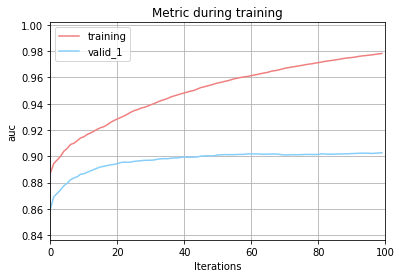

In [ ]:
lgb.plot_metric(model, metric="auc")

##### スコアの提出（Score: 0.79845）

In [ ]:
# predict with validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# convert to bool with threshold is 0.5
y_pred = y_pred_proba >= 0.5
display(y_pred)

submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

array([False, False,  True, ...,  True,  True,  True])

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


#### (orig)_log：○、 (orig)：× のパターン

In [ ]:
feature_columns = all_data_log.columns

In [ ]:
print(feature_columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'TotalSpend', 'PctRoomService', 'PctFoodCourt',
       'PctShoppingMall', 'PctSpa', 'PctVRDeck', 'Room', 'Deck', 'Side',
       'Cabin_num', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6',
       'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log',
       'VRDeck_log', 'PctRoomService_log', 'PctFoodCourt_log',
       'PctShoppingMall_log', 'PctSpa_log', 'PctVRDeck_log'],
      dtype='object')


In [ ]:
feature_columns = [i for i in feature_columns if i not in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']]

##### Train と Test を分割する

In [ ]:
train, X_test = all_data_log[feature_columns].iloc[:train.shape[0]], all_data_log[feature_columns].iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(8693, 30)
(8693,)
(4277, 30)


##### y_train の Transported が bool型になっている（分類器に入れられない）ので、intに変換

In [ ]:
# y_train が bool型になっているので、intに変換する
y_train = y_train.astype("int")

##### Validate のため、Train をさらに分割する

In [ ]:
X_train_va, X_test_va, y_train_va, y_test_va  = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print(X_train_va.shape, y_train_va.shape)

(6085, 30) (6085,)


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = LGBMClassifier(objective='binary')

model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc')

# predict with validation data
y_pred = model.predict_proba(X_test_va)[:, 1]
# convert to bool with threshold is 0.5
y_pred = y_pred >= 0.5
#roc_auc_score metric
accuracy = accuracy_score(y_pred,list(y_test_va))

[1]	training's auc: 0.887576	training's binary_logloss: 0.648039	valid_1's auc: 0.860141	valid_1's binary_logloss: 0.65206
[2]	training's auc: 0.894568	training's binary_logloss: 0.610589	valid_1's auc: 0.869277	valid_1's binary_logloss: 0.617255
[3]	training's auc: 0.897171	training's binary_logloss: 0.579455	valid_1's auc: 0.871781	valid_1's binary_logloss: 0.588822
[4]	training's auc: 0.899952	training's binary_logloss: 0.553141	valid_1's auc: 0.874501	valid_1's binary_logloss: 0.564937
[5]	training's auc: 0.903833	training's binary_logloss: 0.530729	valid_1's auc: 0.877608	valid_1's binary_logloss: 0.544775
[6]	training's auc: 0.905992	training's binary_logloss: 0.511111	valid_1's auc: 0.879517	valid_1's binary_logloss: 0.527008
[7]	training's auc: 0.909006	training's binary_logloss: 0.493393	valid_1's auc: 0.882184	valid_1's binary_logloss: 0.511301
[8]	training's auc: 0.909952	training's binary_logloss: 0.478125	valid_1's auc: 0.883568	valid_1's binary_logloss: 0.497534
[9]	train

In [ ]:
print(accuracy)

0.8067484662576687


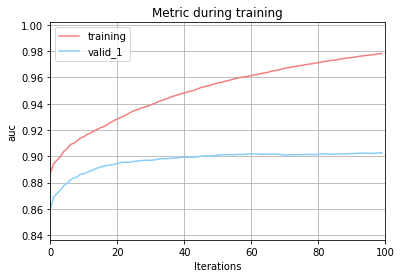

In [ ]:
lgb.plot_metric(model, metric="auc")

##### スコアの提出（Score: 0.79845）

In [ ]:
# predict with validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# convert to bool with threshold is 0.5
y_pred = y_pred_proba >= 0.5
display(y_pred)

submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

array([False, False,  True, ...,  True,  True,  True])

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


#### (orig)_log：×、 (orig)：○ のパターン（対数変換無し）

In [ ]:
feature_columns = all_data_log.columns

In [ ]:
print(feature_columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'TotalSpend', 'PctRoomService', 'PctFoodCourt',
       'PctShoppingMall', 'PctSpa', 'PctVRDeck', 'Room', 'Deck', 'Side',
       'Cabin_num', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6',
       'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log',
       'VRDeck_log', 'PctRoomService_log', 'PctFoodCourt_log',
       'PctShoppingMall_log', 'PctSpa_log', 'PctVRDeck_log'],
      dtype='object')


In [ ]:
feature_columns = [i for i in feature_columns if i not in ['RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log', 'VRDeck_log','PctRoomService_log', 'PctFoodCourt_log', 'PctShoppingMall_log', 'PctSpa_log', 'PctVRDeck_log']]

##### Train と Test を分割する

In [ ]:
train, X_test = all_data_log[feature_columns].iloc[:train.shape[0]], all_data_log[feature_columns].iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(8693, 30)
(8693,)
(4277, 30)


##### y_train の Transported が bool型になっている（分類器に入れられない）ので、intに変換

In [ ]:
# y_train が bool型になっているので、intに変換する
y_train = y_train.astype("int")

##### Validate のため、Train をさらに分割する

In [ ]:
X_train_va, X_test_va, y_train_va, y_test_va  = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
print(X_train_va.shape, y_train_va.shape)

(6085, 30) (6085,)


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
model = LGBMClassifier(objective='binary')

model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc')

# predict with validation data
y_pred = model.predict_proba(X_test_va)[:, 1]
# convert to bool with threshold is 0.5
y_pred = y_pred >= 0.5
#roc_auc_score metric
accuracy = accuracy_score(y_pred,list(y_test_va))

[1]	training's auc: 0.887576	training's binary_logloss: 0.648039	valid_1's auc: 0.860141	valid_1's binary_logloss: 0.65206
[2]	training's auc: 0.894568	training's binary_logloss: 0.610589	valid_1's auc: 0.869277	valid_1's binary_logloss: 0.617255
[3]	training's auc: 0.897171	training's binary_logloss: 0.579455	valid_1's auc: 0.871781	valid_1's binary_logloss: 0.588822
[4]	training's auc: 0.899952	training's binary_logloss: 0.553141	valid_1's auc: 0.874501	valid_1's binary_logloss: 0.564937
[5]	training's auc: 0.903833	training's binary_logloss: 0.530729	valid_1's auc: 0.877608	valid_1's binary_logloss: 0.544775
[6]	training's auc: 0.905992	training's binary_logloss: 0.511111	valid_1's auc: 0.879517	valid_1's binary_logloss: 0.527008
[7]	training's auc: 0.909006	training's binary_logloss: 0.493393	valid_1's auc: 0.882184	valid_1's binary_logloss: 0.511301
[8]	training's auc: 0.909952	training's binary_logloss: 0.478125	valid_1's auc: 0.883568	valid_1's binary_logloss: 0.497534
[9]	train

In [ ]:
print(accuracy)

0.8067484662576687


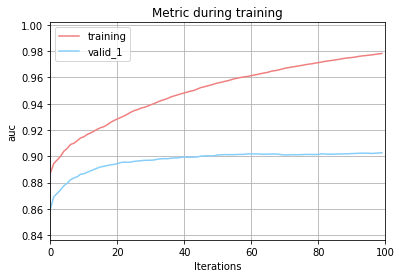

In [ ]:
lgb.plot_metric(model, metric="auc")

##### スコアの提出（Score: 0.79845）

In [ ]:
# predict with validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# convert to bool with threshold is 0.5
y_pred = y_pred_proba >= 0.5
display(y_pred)

submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

array([False, False,  True, ...,  True,  True,  True])

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


## パラメータチューニング

### モデルの最適化過程をデータベースに保存する方法

In [ ]:
import optuna
# ベイズ最適化時の評価指標算出メソッド
# 学習時fitパラメータ指定
fit_params = {'callbacks': [lgb.early_stopping(
                  stopping_rounds=20, # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
                  verbose=0)],  # 学習中のコマンドライン出力
              'eval_metric': 'accuracy',  # early_stopping_roundsの評価指標
              'eval_set': [(X_train_va, y_train_va)]  # early_stopping_roundsの評価指標算出用データ
              }

def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0000, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0000, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 20)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    model.fit(X_train_va, y_train_va,eval_set=[(X_train_va, y_train_va),(X_test_va, y_test_va)], eval_metric='auc')
    
    # predict with validation data
    y_pred = model.predict_proba(X_test_va)[:, 1]
    # convert to bool with threshold is 0.5
    y_pred = y_pred >= 0.5
    #roc_auc_score metric
    accuracy = accuracy_score(y_pred,list(y_test_va))

    return accuracy
study_name = "230214_test"
db_name = 'sqlite:///230214_optuna.db'

# ベイズ最適化を実行
study = optuna.create_study(study_name = study_name, direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=500), storage=db_name, load_if_exists = True)
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')


### クロスバリデーションをしながらハイパーパラメータチューニング

In [ ]:
import optuna
import lightgbm as lgb
from lightgbm import LGBMClassifier
# ベイズ最適化時の評価指標算出メソッド
# 学習時fitパラメータ指定
fit_params = {'callbacks': [lgb.early_stopping(
                  stopping_rounds=100, # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
                  verbose=0)],  # 学習中のコマンドライン出力
              'eval_metric': 'accuracy',  # early_stopping_roundsの評価指標
              'eval_set': [(X_train_va, y_train_va)]  # early_stopping_roundsの評価指標算出用データ
              }

def bayes_objective(trial):
    params = {
        
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0000, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0000, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 20),
        "max_depth": trial.suggest_int('max_depth', 0, 20),
        "min_data_in_leaf":trial.suggest_int('min_data_in_leaf', 10, 500),
    }

    # CVの数N
    N = 5

    # モデルにパラメータ適用
    model = LGBMClassifier(n_estimators = 10000, objective='binary')

    classfier_obj = model.set_params(**params)
    score = cross_val_score(classfier_obj,X_train,y_train,n_jobs=1,cv = N,scoring = "accuracy")
    accuracy_mean = score.mean()

    

    return accuracy_mean
study_name = "230218_optm"
db_name = 'sqlite:///230218_optuna.db'

# ベイズ最適化を実行
study = optuna.create_study(study_name = study_name, direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=500), storage=db_name, load_if_exists = True)
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')


#### 一時間で30 trials

In [ ]:
from optuna.integration import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
# LightGBM のデータセット表現にする
lgb_train = lgb.Dataset(X_train, y_train)

# データセットの分割方法
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 最適化するときの条件
lgbm_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
}
# 基本的には cv() 関数のオプションがそのまま渡せる
tuner_cv = lgb.LightGBMTunerCV(
    lgbm_params, lgb_train,
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=20,
    folds=folds,
    
)

# 最適なパラメータを探索する
tuner_cv.run()

# 最も良かったスコアとパラメータを書き出す
print(f'Best score: {tuner_cv.best_score}')
print('Best params:')